<a href="https://colab.research.google.com/github/hwon-n/cp2/blob/hyewon/CP2_KoSpacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 띄어쓰기 검사 모델 구현하기

## 필요한 패키지 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kss

     |████████████████████████████████| 42.4 MB 1.3 MB/s 
     |████████████████████████████████| 175 kB 66.8 MB/s 
  Created wheel for kss: filename=kss-3.4-py3-none-any.whl size=42449209 sha256=7e81a358f2fba07615b4a093daf1f19fe646f57fbdb38ecf15f212389ae140cc
  Stored in directory: /root/.cache/pip/wheels/06/8e/5b/305f0a804fba3943f353f1b0e3cb1fad39e4f5ae4893ea9590
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=25853ffdc07b96827ce20d6c3657d1888d1710155f3f1e196e71eea1413d4217
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built kss emoji


In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 14.7 MB/s 


In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 527 kB 14.8 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 952 kB 56.4 MB/s 
     |████████████████████████████████| 134 kB 74.5 MB/s 
     |████████████████████████████████| 397 kB 84.1 MB/s 
     |████████████████████████████████| 829 kB 68.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.6 MB/s 
     |████████████████████████████████| 144 kB 72.6 MB/s 
     |████████████████████████████████| 271 kB 64.2 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=598e8903fbb4e726e26e5307f212200eb2bbfc0818cb64c888d9465cfc679788
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

In [ ]:
pip install omegaconf

     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 36.9 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=91697d03234515be4c8eaacd2351984acd7e0655d9dd8ea1c5ceb44188b185a7
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime


In [ ]:
pip install seqeval

     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=39b0ec4c01ce29b1687092a35b8315af36c754814aab642496c95010b05b0781
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
pip install torch

In [ ]:
pip install tokenizers

     |████████████████████████████████| 6.5 MB 12.1 MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 3.8 MB 15.2 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 


In [ ]:
import pytorch_lightning
pytorch_lightning.__version__

'1.5.10'

## 데이터 불러오기

In [ ]:
import os

root = '/content/drive/MyDrive/news_class9x1400/'
categories = os.listdir(root)

dataset = []

for cat in categories:
  files = os.listdir(root + cat)
  for i, f in enumerate(files):
    fname = root + cat + '/' + f
    file = open(fname, 'r', encoding='utf-8')
    strings = file.read()
    dataset.append([strings])
    file.close()

print(len(dataset))

12600


In [ ]:
import random

random.shuffle(dataset)
mini_dataset = dataset[:800]

In [ ]:
mini_dataset[241]

['정세균 유명환 장관 욕설, 기절초풍할 상황\n민주당이 지난 22일 외통위에서 천정배 의원을 가리키며 미친X 욕설을 한 유명환 외교통상부장관의 경질을 요구하고 나섰다.\n정세균 대표는 29일 오전 국회 본관 246호에서 열린 의원총회 모두발언을 통해 속된 말로 기절초풍할 상황이 대한민국 국회에서 벌어졌다며 국회 경시하는 풍조가 벌써 몇 번째냐, 총리부터 시작해서 문화부 장관, 기획재정부 장관, 거기에 외교부 장관까지 가세를 하는 형국이 됐다고 비판했다.\n정 대표는 또 사적인 술자리에서 그런 얘기를 해도 용납될 수 없는 일인데, 국회에 장관이 나와서 국무위원석에 앉아서 야당 중진의원에게 그런 얘기를 했다는 것이 기가 막힐 노릇이라며 절대 용납해서는 안 된다고 목소리를 높였다.\n이어 그는 한승수 총리가 공개적으로 사과하고 유명환 외교부 장관은 스스로 사퇴해야 한다며 만약 사퇴하지 않으면 대통령이 경질해야 한다고 주장했다.\n아울러 정 대표는 각 상임위에서 정부 각료들의 버릇을 뜯어고쳐야 한다며 민주당 의원들에게 강력한 대응을 요청했다.\n그는 입법부는 국민의 대표가 나와서 국민을 대신해서 일을 하고 있는 것인데, 장관들이 어떻게 이런 짓을 할 수 있느냐면서 이 부분에 대해서 확실하게 노력해 주시기 바란다고 말했다.\n노영민 대변인도 공식 브리핑을 통해 유명환 장관을 강력히 비난했다.\n노 대변인은 유 장관을 향해 국무위원의 발언이라고는 생각하기 어려운 시정잡배 같은 막말이라고 비판한 뒤 국회를 없애야 한다는 위험천만한 발언을 국민이 어떻게 받아들일지 걱정이라고 지적했다.\n노 대변인은 또 도대체 이 정부 국무위원들의 수준이 왜 이런지 모르겠다면서 유유상종이라는 말도 있고, 윗물이 맑아야 아랫물이 맑다는 얘기도 있다, 이명박 대통령은 제발 주변 좀 돌아보시기 바란다고 성토했다.\n박병석 정책위원장도 이날 오전 <불교방송> 김재원의 아침저널에 출연해 유 장관의 발언에 대해 분노와 자괴감이 든다면서 한나라당이 청와대의 지시와 방침에 맹종하기 때문에 이런 경시 문제

## 데이터 전처리

In [ ]:
table = str.maketrans({
    '\'': '',
    '\"': '',
    '★': '',
    '▲': '',
    '┌': '',
    '├': '',
    '│': '',
    '└': '',
    '→': ''

})
test = '"안녕"하세★요? 좋은 아▲침입┌니├다. 오│늘도 힘내└세요→!'
test = test.translate(table)

test

'안녕하세요? 좋은 아침입니다. 오늘도 힘내세요!'

In [ ]:
import kss
import random

process_dataset = []

for sentences in mini_dataset:
  sentences = sentences[0]
  sentences = sentences.translate(table)
  sentences = sentences.split("\n")

  for sentence in sentences:
    process_dataset.extend(kss.split_sentences(sentence))


len(process_dataset)

31800

In [ ]:
# 4h 36m 

len(process_dataset)

31800

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(process_dataset, test_size = 0.2, random_state  = 42)
train, val = train_test_split(train, test_size = 0.2, random_state = 42)

print(len(train), len(val), len(test))

20352 5088 6360


In [ ]:
def save_datafile(file_name, dataset):
  with open(
      os.path.join(root, file_name), mode = 'w', encoding='utf-8'
  ) as f:
    for data in dataset:
      f.write(data)

save_datafile('train.txt', train)
save_datafile('val.txt', val)
save_datafile('test.txt', test)

print('train, val, test dataset 저장 완료!')

train, val, test dataset 저장 완료!


In [ ]:
train[11901]

'올 시즌의 브랜드는 자신과 같이 트윈타워를 이루는 하승진을 잘 이용해주고 있다.'

In [ ]:
val[3452]

'그리하여 늘 양심을 생각하면서'

In [ ]:
test[999]

'말글 얼거리를 잘 모르는 어리보기가 국어사전을 엮었다면 모르되, 우리 말글 얼거리를 깊이 헤아리고 익히고 가다듬는다는 국어학자가 이렇게 국어사전을 엮었다면 더없이 슬프고 안타까운 노릇입니다.'

## 띄어쓰기를 위한 클래스

In [ ]:
from typing import List

def load_slot_labels() -> List[str]:
    """tag label 종류 리턴"""
    return ["UNK", "PAD", "O", "B", "I", "E", "S"]

In [ ]:
from typing import Callable, List, Tuple
from torch.utils.data import Dataset

class CorpusDataset(Dataset):
    def __init__(self, data_path: str, transform: Callable[[List, List], Tuple]):
        self.sentences = []
        self.transform = transform
        self.slot_labels = load_slot_labels()

        self._load_data(data_path)

    def _load_data(self, data_path: str):
        """data를 file에서 불러온다.
        Args:
            data_path: file 경로
        """
        with open(data_path, mode="r", encoding="utf-8") as f:
            lines = f.readlines()
            self.sentences = [line.split() for line in lines]

    def _get_tags(self, sentence: List[str]) -> List[str]:
        """문장에 대해 띄어쓰기 tagging을 한다.
        character 단위로 분리하여 BIES tagging을 한다.
        Args:
            sentence: 문장
        Retrns:
            문장의 각 토큰에 대해 tagging한 결과 리턴
            ["B", "I", "E"]
        """

        all_tags = []
        for word in sentence:
            if len(word) == 1:
                all_tags.append("S")
            elif len(word) > 1:
                for i, c in enumerate(word):
                    if i == 0:
                        all_tags.append("B")
                    elif i == len(word) - 1:
                        all_tags.append("E")
                    else:
                        all_tags.append("I")
        return all_tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = "".join(self.sentences[idx])
        tags = self._get_tags(self.sentences[idx])
        tags = [self.slot_labels.index(t) for t in tags]

        (
            input_ids,
            slot_labels,
            attention_mask,
            token_type_ids,
        ) = self.transform(sentence, tags)

        return input_ids, slot_labels, attention_mask, token_type_ids

### Tokenization_kobert


In [ ]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBERT model """


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [ ]:
import torch

class Preprocessor:
    def __init__(self, max_len: int):
        self.tokenizer = KoBertTokenizer.from_pretrained("monologg/kobert")
        self.max_len = max_len
        self.pad_token_id = 0

    def get_input_features(
        self, sentence: List[str], tags: List[str]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """문장과 띄어쓰기 tagging에 대해 feature로 변환한다.
        Args:
            sentence: 문장
            tags: 띄어쓰기 tagging
        Returns:
            feature를 리턴한다.
            input_ids, attention_mask, token_type_ids, slot_labels
        """

        input_tokens = []
        slot_labels = []

        for word, tag in zip(sentence, tags):
            tokens = self.tokenizer.tokenize(word)

            if len(tokens) == 0:
                tokens = self.tokenizer.unk_token

            input_tokens.extend(tokens)

            for i, _ in enumerate(tokens):
                if i == 0:
                    slot_labels.extend([tag])
                else:
                    slot_labels.extend([self.pad_token_id])

        # 2. max_len보다 길이가 길면 뒤에 자르기
        if len(input_tokens) > self.max_len - 2:
            input_tokens = input_tokens[: self.max_len - 2]
            slot_labels = slot_labels[: self.max_len - 2]

        # cls, sep 추가
        input_tokens = (
            [self.tokenizer.cls_token] + input_tokens + [self.tokenizer.sep_token]
        )
        slot_labels = [self.pad_token_id] + slot_labels + [self.pad_token_id]

        # token을 id로 변환
        input_ids = self.tokenizer.convert_tokens_to_ids(input_tokens)

        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        # padding
        pad_len = self.max_len - len(input_tokens)
        input_ids = input_ids + ([self.tokenizer.pad_token_id] * pad_len)
        slot_labels = slot_labels + ([self.pad_token_id] * pad_len)
        attention_mask = attention_mask + ([0] * pad_len)
        token_type_ids = token_type_ids + ([0] * pad_len)

        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
        slot_labels = torch.tensor(slot_labels, dtype=torch.long)

        return input_ids, attention_mask, token_type_ids, slot_labels

## 모델 생성

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import BertConfig, BertModel, AdamW
from torch.utils.data import DataLoader
from seqeval.metrics import f1_score


class SpacingBertModel(pl.LightningModule):
    def __init__(
        self,
        config,
        ner_train_dataloader: DataLoader,
        ner_val_dataloader: DataLoader,
        ner_test_dataloader: DataLoader,
    ):
        super().__init__()
        self.config = config
        self.ner_train_dataloader = ner_train_dataloader
        self.ner_val_dataloader = ner_val_dataloader
        self.ner_test_dataloader = ner_test_dataloader
        self.slot_labels_type = load_slot_labels()
        self.pad_token_id = 0

        self.bert_config = BertConfig.from_pretrained(
            self.config.bert_model, num_labels=len(self.slot_labels_type)
        )
        self.model = BertModel.from_pretrained(
            self.config.bert_model, config=self.bert_config
        )
        self.dropout = nn.Dropout(self.config.dropout_rate)
        self.linear = nn.Linear(
            self.bert_config.hidden_size, len(self.slot_labels_type)
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        x = outputs[0]
        x = self.dropout(x)
        x = self.linear(x)

        return x

    def training_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        loss = self._calculate_loss(outputs, slot_labels)
        tensorboard_logs = {"train_loss": loss}

        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        loss = self._calculate_loss(outputs, slot_labels)
        self.log('val_loss', loss)
        gt_slot_labels, pred_slot_labels = self._convert_ids_to_labels(
            outputs, slot_labels
        )

        val_acc = self._f1_score(gt_slot_labels, pred_slot_labels)

        return {"val_loss": loss, "val_acc": val_acc}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_acc = torch.stack([x["val_acc"] for x in outputs]).mean()

        tensorboard_log = {
            "val_loss": val_loss,
            "val_acc": val_acc,
        }

        return {"val_loss": val_loss, "progress_bar": tensorboard_log}

    def test_step(self, batch, batch_nb):

        input_ids, attention_mask, token_type_ids, slot_labels = batch

        outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        gt_slot_labels, pred_slot_labels = self._convert_ids_to_labels(
            outputs, slot_labels
        )

        test_acc = self._f1_score(gt_slot_labels, pred_slot_labels)

        test_step_outputs = {
            "test_acc": test_acc,
            "gt_labels": gt_slot_labels,
            "pred_labels": pred_slot_labels,
        }

        return test_step_outputs

    def test_epoch_end(self, outputs):
        test_acc = torch.stack([x["test_acc"] for x in outputs]).mean()

        gt_labels = []
        pred_labels = []
        for x in outputs:
            gt_labels.extend(x["gt_labels"])
            pred_labels.extend(x["pred_labels"])

        test_step_outputs = {
            "test_acc": test_acc,
            "gt_labels": gt_labels,
            "pred_labels": pred_labels,
        }

        return test_step_outputs

    def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr=2e-5, eps=1e-8)

    def train_dataloader(self):
        return self.ner_train_dataloader

    def val_dataloader(self):
        return self.ner_val_dataloader

    def test_dataloader(self):
        return self.ner_test_dataloader

    def _calculate_loss(self, outputs, labels):
        # active_loss = attention_mask.view(-1) == 1
        # active_logits = outputs.view(-1, len(self.slot_labels_type))[active_loss]
        # active_labels = slot_labels.view(-1)[active_loss]
        active_logits = outputs.view(-1, len(self.slot_labels_type))
        active_labels = labels.view(-1)
        loss = F.cross_entropy(active_logits, active_labels)

        return loss

    def _f1_score(self, gt_slot_labels, pred_slot_labels):
        return torch.tensor(
            f1_score(gt_slot_labels, pred_slot_labels), dtype=torch.float32
        )

    def _convert_ids_to_labels(self, outputs, slot_labels):
        _, y_hat = torch.max(outputs, dim=2)
        y_hat = y_hat.detach().cpu().numpy()
        slot_label_ids = slot_labels.detach().cpu().numpy()

        slot_label_map = {i: label for i, label in enumerate(self.slot_labels_type)}
        slot_gt_labels = [[] for _ in range(slot_label_ids.shape[0])]
        slot_pred_labels = [[] for _ in range(slot_label_ids.shape[0])]

        for i in range(slot_label_ids.shape[0]):
            for j in range(slot_label_ids.shape[1]):
                if slot_label_ids[i, j] != self.pad_token_id:
                    slot_gt_labels[i].append(slot_label_map[slot_label_ids[i][j]])
                    slot_pred_labels[i].append(slot_label_map[y_hat[i][j]])

        return slot_gt_labels, slot_pred_labels

## 모델 학습

In [ ]:
train_data_path = '/content/drive/MyDrive/news_class9x1400/train.txt'
test_data_path = '/content/drive/MyDrive/news_class9x1400/test.txt'
val_data_path = '/content/drive/MyDrive/news_class9x1400/val.txt'

In [ ]:
from omegaconf import OmegaConf

config = OmegaConf.load('/content/drive/MyDrive/train_config.yaml')

In [ ]:
def get_dataloader(
    data_path: str, transform: Callable[[List, List], Tuple], batch_size: int
) -> DataLoader:
    """dataloader 생성
    Args:
        data_path: dataset 경로
        transform: input feature로 변환해주는 funciton
        batch_size: dataloader batch size
    Returns:
        dataloader
    """
    dataset = CorpusDataset(data_path, transform)
    print(dataset[0])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [ ]:
preprocessor = Preprocessor(config.max_len)

train_dataloader = get_dataloader(
    config.train_data_path, preprocessor.get_input_features, config.train_batch_size
)
val_dataloader = get_dataloader(
    config.val_data_path, preprocessor.get_input_features, config.train_batch_size
)
test_dataloader = get_dataloader(
    config.test_data_path, preprocessor.get_input_features, config.eval_batch_size
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


(tensor([   2, 3376, 5112,  517, 7095, 1907, 4662,  517, 7681, 3647, 2044, 1773,
        1185,  517, 6983, 1073,  517, 6067, 1763, 3220, 3854,  517, 5760,  905,
         517, 7086,  937, 4665, 3498, 3332, 3647, 3093,  517, 5770, 1562,  517,
          54, 3758, 2573, 1958,  517, 6896, 1370, 2734, 4519, 1103, 4360, 4743,
        3803, 1103, 3597,  517, 7911,  517, 7095, 5152, 5152, 3954,  517, 7086,
        1363, 3270, 3647, 1132, 2169,  517, 7088, 2573,  517, 6022, 5017,  993,
         517,   46, 2169, 4213, 4213,  517, 7095,  517, 6116,  781, 1968, 5017,
         517, 7074,  517, 6197,  517,   46, 4955, 2169,  517, 7263,  517, 5468,
        2801,  980, 4841, 5112,  517, 6116, 3374, 3533, 5017,  517, 5842, 1316,
        1633, 4257, 4012, 1633, 4743,  517, 6077,  517, 7088, 3498, 1900,  517,
        7095, 1633, 4743,  517, 6077,  517, 7074,    3]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
bert_finetuner = SpacingBertModel(
    config, 
    train_dataloader, 
    val_dataloader, 
    test_dataloader
)

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

In [ ]:
import os
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

logger = TensorBoardLogger(
    save_dir = config.log_path,
    version = 1,
    name = config.task
)

checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints/{epoch}_{val_loss:3f}',
    verbose = True,
    monitor = 'val_loss',
    mode = 'min',
    save_top_k = 3,
)

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 3,
    mode = 'min',
)

In [ ]:
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla P100-PCIE-16GB


In [ ]:
# GPU 설정
device = torch.device("cuda:0")

In [ ]:
trainer = pl.Trainer(
    gpus = config.gpus,
    callbacks = [early_stop_callback, checkpoint_callback],
    strategy = config.strategy,
    logger = logger,
)

trainer.fit(bert_finetuner, val_dataloader)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name    | Type      | Params
--------------------------------------
0 | model   | BertModel | 92.2 M
1 | dropout | Dropout   | 0     
2 | linear  | Linear    | 5.4 K 
--------------------------------------
92.2 M    Trainable params
0         Non-trainable params
92.2 M    Total params
368.769   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: UNK seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 0: val_loss reached 1.75301 (best 1.75301), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=0-step=0.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 1: val_loss reached 1.62344 (best 1.62344), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=1-step=1.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 2: val_loss reached 1.53141 (best 1.53141), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=2-step=2.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 3: val_loss reached 1.46533 (best 1.46533), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=3-step=3.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 4: val_loss reached 1.40461 (best 1.40461), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=4-step=4.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 5: val_loss reached 1.34566 (best 1.34566), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=5-step=5.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 6: val_loss reached 1.29440 (best 1.29440), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=6-step=6.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 7: val_loss reached 1.24916 (best 1.24916), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=7-step=7.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 8: val_loss reached 1.20494 (best 1.20494), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=8-step=8.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 9: val_loss reached 1.15950 (best 1.15950), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=9-step=9.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 10: val_loss reached 1.11178 (best 1.11178), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=10-step=10.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 11: val_loss reached 1.06425 (best 1.06425), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=11-step=11.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 12: val_loss reached 1.01762 (best 1.01762), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=12-step=12.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 13: val_loss reached 0.97216 (best 0.97216), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=13-step=13.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 14: val_loss reached 0.92814 (best 0.92814), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=14-step=14.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 15: val_loss reached 0.88543 (best 0.88543), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=15-step=15.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 16: val_loss reached 0.84234 (best 0.84234), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=16-step=16.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 17: val_loss reached 0.79938 (best 0.79938), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=17-step=17.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 18: val_loss reached 0.75781 (best 0.75781), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=18-step=18.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 19: val_loss reached 0.71778 (best 0.71778), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=19-step=19.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 20: val_loss reached 0.67970 (best 0.67970), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=20-step=20.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 21: val_loss reached 0.64278 (best 0.64278), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=21-step=21.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 22: val_loss reached 0.61085 (best 0.61085), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=22-step=22.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 23: val_loss reached 0.58253 (best 0.58253), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=23-step=23.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 24: val_loss reached 0.55593 (best 0.55593), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=24-step=24.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 25: val_loss reached 0.52985 (best 0.52985), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=25-step=25.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 26: val_loss reached 0.50532 (best 0.50532), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=26-step=26.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 27: val_loss reached 0.48157 (best 0.48157), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=27-step=27.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 28: val_loss reached 0.45811 (best 0.45811), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=28-step=28.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 29: val_loss reached 0.43353 (best 0.43353), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=29-step=29.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 30: val_loss reached 0.40781 (best 0.40781), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=30-step=30.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 31: val_loss reached 0.38246 (best 0.38246), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=31-step=31.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 32: val_loss reached 0.36081 (best 0.36081), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=32-step=32.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 33: val_loss reached 0.34073 (best 0.34073), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=33-step=33.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 34: val_loss reached 0.32083 (best 0.32083), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=34-step=34.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 35: val_loss reached 0.30172 (best 0.30172), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=35-step=35.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 36: val_loss reached 0.28184 (best 0.28184), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=36-step=36.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 37: val_loss reached 0.26096 (best 0.26096), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=37-step=37.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 38: val_loss reached 0.24043 (best 0.24043), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=38-step=38.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 39: val_loss reached 0.21980 (best 0.21980), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=39-step=39.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 40: val_loss reached 0.20019 (best 0.20019), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=40-step=40.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 41: val_loss reached 0.18601 (best 0.18601), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=41-step=41.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 42: val_loss reached 0.17357 (best 0.17357), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=42-step=42.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 43: val_loss reached 0.16362 (best 0.16362), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=43-step=43.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 44: val_loss reached 0.15503 (best 0.15503), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=44-step=44.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 45: val_loss reached 0.14593 (best 0.14593), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=45-step=45.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 46: val_loss reached 0.13760 (best 0.13760), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=46-step=46.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 47: val_loss reached 0.12963 (best 0.12963), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=47-step=47.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 48: val_loss reached 0.12228 (best 0.12228), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=48-step=48.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 49: val_loss reached 0.11545 (best 0.11545), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=49-step=49.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 50: val_loss reached 0.10882 (best 0.10882), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=50-step=50.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 51: val_loss reached 0.10234 (best 0.10234), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=51-step=51.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 52, global step 52: val_loss reached 0.09688 (best 0.09688), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=52-step=52.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 53, global step 53: val_loss reached 0.09273 (best 0.09273), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=53-step=53.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 54, global step 54: val_loss reached 0.08934 (best 0.08934), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=54-step=54.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 55, global step 55: val_loss reached 0.08608 (best 0.08608), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=55-step=55.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 56, global step 56: val_loss reached 0.08293 (best 0.08293), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=56-step=56.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 57, global step 57: val_loss reached 0.07943 (best 0.07943), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=57-step=57.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 58, global step 58: val_loss reached 0.07663 (best 0.07663), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=58-step=58.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 59, global step 59: val_loss reached 0.07381 (best 0.07381), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=59-step=59.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 60: val_loss reached 0.07123 (best 0.07123), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=60-step=60.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 61, global step 61: val_loss reached 0.06869 (best 0.06869), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=61-step=61.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 62, global step 62: val_loss reached 0.06631 (best 0.06631), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=62-step=62.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 63, global step 63: val_loss reached 0.06413 (best 0.06413), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=63-step=63.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 64, global step 64: val_loss reached 0.06222 (best 0.06222), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=64-step=64.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 65, global step 65: val_loss reached 0.06057 (best 0.06057), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=65-step=65.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 66, global step 66: val_loss reached 0.05910 (best 0.05910), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=66-step=66.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 67, global step 67: val_loss reached 0.05778 (best 0.05778), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=67-step=67.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 68, global step 68: val_loss reached 0.05660 (best 0.05660), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=68-step=68.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 69, global step 69: val_loss reached 0.05553 (best 0.05553), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=69-step=69.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 70, global step 70: val_loss reached 0.05460 (best 0.05460), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=70-step=70.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 71, global step 71: val_loss reached 0.05378 (best 0.05378), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=71-step=71.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 72, global step 72: val_loss reached 0.05303 (best 0.05303), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=72-step=72.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 73, global step 73: val_loss reached 0.05234 (best 0.05234), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=73-step=73.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 74, global step 74: val_loss reached 0.05168 (best 0.05168), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=74-step=74.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 75, global step 75: val_loss reached 0.05099 (best 0.05099), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=75-step=75.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 76, global step 76: val_loss reached 0.05023 (best 0.05023), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=76-step=76.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 77, global step 77: val_loss reached 0.04947 (best 0.04947), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=77-step=77.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 78, global step 78: val_loss reached 0.04867 (best 0.04867), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=78-step=78.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 79, global step 79: val_loss reached 0.04785 (best 0.04785), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=79-step=79.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 80, global step 80: val_loss reached 0.04708 (best 0.04708), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=80-step=80.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 81, global step 81: val_loss reached 0.04636 (best 0.04636), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=81-step=81.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 82, global step 82: val_loss reached 0.04567 (best 0.04567), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=82-step=82.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 83, global step 83: val_loss reached 0.04505 (best 0.04505), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=83-step=83.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 84, global step 84: val_loss reached 0.04449 (best 0.04449), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=84-step=84.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 85, global step 85: val_loss reached 0.04398 (best 0.04398), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=85-step=85.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 86, global step 86: val_loss reached 0.04350 (best 0.04350), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=86-step=86.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 87, global step 87: val_loss reached 0.04305 (best 0.04305), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=87-step=87.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 88, global step 88: val_loss reached 0.04262 (best 0.04262), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=88-step=88.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 89, global step 89: val_loss reached 0.04222 (best 0.04222), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=89-step=89.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 90, global step 90: val_loss reached 0.04185 (best 0.04185), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=90-step=90.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 91, global step 91: val_loss reached 0.04147 (best 0.04147), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=91-step=91.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 92, global step 92: val_loss reached 0.04112 (best 0.04112), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=92-step=92.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 93, global step 93: val_loss reached 0.04081 (best 0.04081), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=93-step=93.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

Epoch 94, global step 94: val_loss reached 0.04052 (best 0.04052), saving model to "/content/checkpoints/{epoch}_{val_loss:3f}/epoch=94-step=94.ckpt" as top 3
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/checkpoints/{epoch}_{val_loss:3f}/epoch=94-step=94.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/checkpoints/{epoch}_{val_loss:3f}/epoch=94-step=94.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

## 테스트


In [ ]:
def testModel(config):
  preprocessor = Preprocessor(config.max_len)
  sample_dataloader = get_dataloader(
      config.test_data_path,
      preprocessor.get_input_features,
      config.eval_batch_size
  )

  model = SpacingBertModel(config, None, None, test_dataloader)
  checkpoint = torch.load(config.ckpt_path, map_location = lambda storage, loc: storage)
  model.load_state_dict(checkpoint['state_dict'])

  trainer = pl.Trainer()
  res = trainer.test(model)

  return res

In [ ]:
def remove_spacing(sentences):
  return str(sentences).replace(' ', '')

In [ ]:
sample_text = '아버지가 방에 들어가셨다.'
text = remove_spacing(sample_text)

with open('/content/drive/MyDrive/data/sample.txt', 'w', encoding='utf-8') as f:
  f.write(text)

e_config = OmegaConf.load('/content/drive/MyDrive/eval_config.yaml')
predict = testModel(e_config)

predict

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


(tensor([   2, 3093, 2302, 4297,  517, 5330, 2267,  517, 6896, 1801, 3220,  517,
        5330,  517, 6604, 1562,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

## vscode test 결과


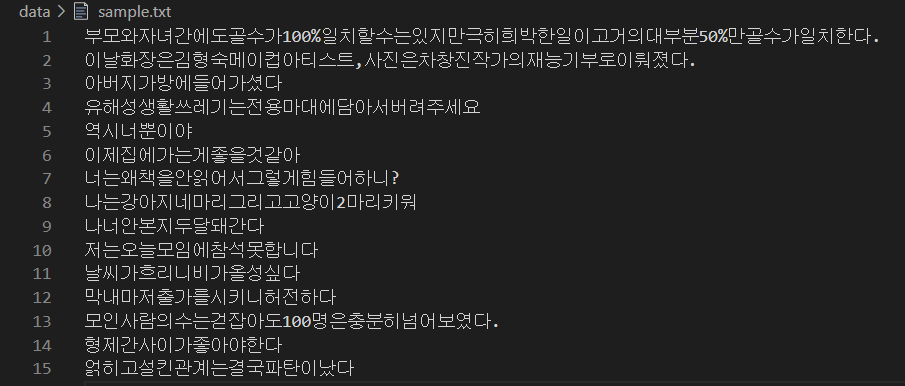

↓↓↓

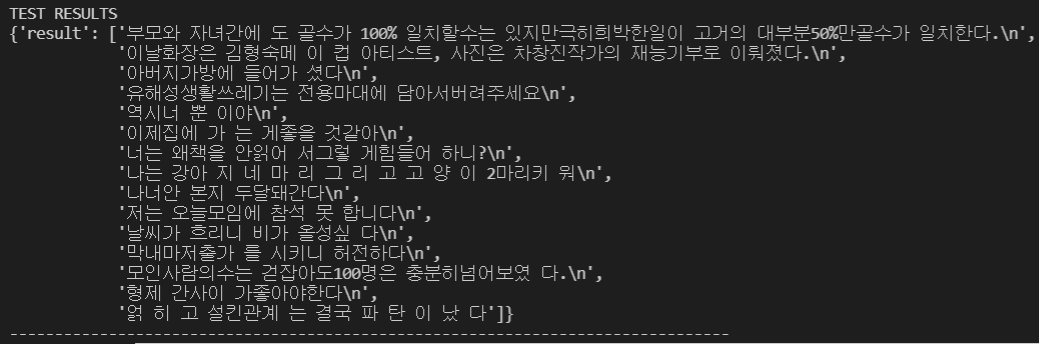